In [1]:
#import modules
import model
import preprocessing as pre
import get_data
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
import pandas as pd
import predict

In [2]:
#dataset directory & preprocessed dataset directory
data_dir = 'dataset/data/'
preprocessed_dir = 'dataset/preprocessed'

In [3]:
labels = ['Butterfly', 'Dragonfly', 'Grasshopper', 'Ladybird', 'Mosquito']
IMG_SIZE = 224

(183, 275)


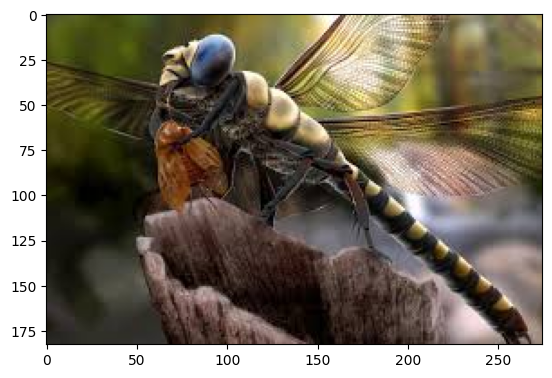

In [4]:
test_img = cv2.imread(data_dir+'/Dragonfly/Dragonfly_15.jpg')
plt.imshow(test_img[:,:,::-1])
print(test_img.shape[:2])

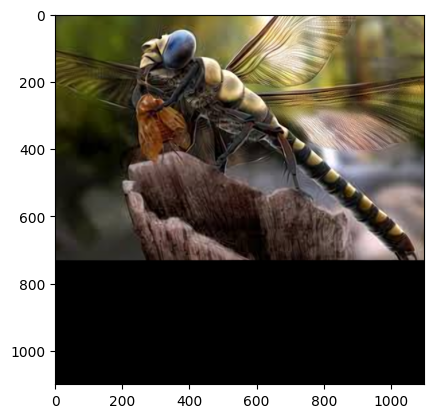

In [5]:
test_result = pre.preprocessing_img(test_img)
plt.imshow(test_result)

In [6]:
#save preprocessed data
pre.save_preprocessed_data(data_dir, preprocessed_dir, labels)

In [ ]:
data = get_data.get_data(preprocessed_dir, labels)
print(len(data))

In [ ]:
#import class mapping
l = []
for i in data:
    l.append(labels[i[1]])

In [ ]:
#show 10 samples
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0][:,:,::-1])
        ax[i,j].set_title('Insect: '+labels[data[l][1]])

plt.tight_layout()

In [ ]:
x = []
y = []
# x array is set of image features
# y array is set of labels 
for feature, label in data:
    x.append(feature)
    y.append(label)

In [ ]:
# Normalize the data

x = np.array(x)
y = np.array(y)

In [ ]:
#divide data into 3 parts with the ratios
#training = 0.6, validation = 0.2, testing = 0.2
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

image_train, image_test, label_train, label_test = train_test_split(x, y, test_size=test_ratio,  stratify = y , random_state = 0)
remaining_ratio = valid_ratio / (train_ratio + valid_ratio)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=remaining_ratio, stratify=label_train, random_state=0)

In [ ]:
del x,y,data

In [ ]:
#build VGG19 model to train data
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = model.build_model(input_layer)
model.compile(loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])
model.summary()

In [ ]:
from keras.utils import plot_model
#show plot model
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
#log file & saved model file directory
log_dir= '../training1.log'
model_dir= '../model1.h5'

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
# setup callbacks and log saving
csv_logger = CSVLogger(log_dir, separator = ',', append = False)
learning_rate_reduction = [ReduceLROnPlateau(monitor='val_loss',
                                                             patience = 2, verbose=1,factor=0.2, min_lr=1e-12),
                           csv_logger]


In [ ]:
epoch = 100

K.clear_session()

model.fit(image_train, label_train, batch_size = 64 , epochs = epoch , validation_data = (image_val, label_val), callbacks = [learning_rate_reduction])
model.save(model_dir)


In [ ]:
# try this code to continue to train when you have log file and model file
# when you go on training model, you needn't to execute above block of code
'''
model = tf.keras.models.load_model(model_dir, compile = False)


log_file_path = log_dir
with open(log_file_path, 'r') as f:
    log_data = f.readlines()

loss_values = []
accuracy_values = []

for line in log_data:
    if 'Epoch' in line and 'loss:' in line and 'accuracy:' in line:
        epoch = int(line.split('Epoch ')[-1].split(' -')[0])
        loss = float(line.split('loss: ')[-1].split(' -')[0])
        accuracy = float(line.split('accuracy: ')[-1].strip())
        loss_values.append(loss)
        accuracy_values.append(accuracy)

initial_epoch = len(loss_values)
epoch2 = initial_epoch + 25
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

csv_logger = CSVLogger(log_dir, separator = ',', append = True)
learning_rate_reduction = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                             patience = 2, verbose=1,factor=0.2, min_lr=0.00000001),
                           csv_logger]
K.clear_session()

model.fit(image_train, label_train, batch_size = 64 , epochs = epoch , validation_data = (image_val, label_val), callbacks = [learning_rate_reduction])
model.save(model_dir)
'''

In [ ]:
model = tf.keras.models.load_model(model_dir, compile = False)
history = pd.read_csv(log_dir, sep =',', engine = 'python')

hist = history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

f,ax=plt.subplots(1,3,figsize=(16,16))
ax[0].set_title('Model Accuracy')
ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].set_title('Model Loss')
ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].set_title('Model Mean IOU')
ax[2].plot(epoch,hist['mean_io_u'],'b',label='Training Mean IOU')
ax[2].plot(epoch,hist['val_mean_io_u'],'r',label='Validation Mean IOU')
ax[2].legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model(model_dir, compile = False)
p1=predict.predict(get_data.get_random_file(data_dir+'/Butterfly'),model)
p2=predict.predict(get_data.get_random_file(data_dir+'/Dragonfly'),model)
p3=predict.predict(get_data.get_random_file(data_dir+'/Grasshopper'),model)
p4=predict.predict(get_data.get_random_file(data_dir+'/Ladybird'),model)
p5=predict.predict(get_data.get_random_file(data_dir+'/Mosquito'),model) 

In [ ]:
conf_mat = np.array([p1[0][0:5], p2[0][0:5], p3[0][0:5], p4[0][0:5], p5[0][0:5]])
predict.confusion_matrix(conf_mat)

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=5)])

result = model.evaluate(image_test, label_test)
print("Loss of model is: ", result[0])
print("Accuracy of the model is: " , result[1]*100 , "%")